## All three responses for the Assignment are in this notebook, marked by Question number

### Note - a copy rendering the maps is located at here: https://nbviewer.jupyter.org/github/sgatea/Coursera_Capstone/blob/master/Segmenting%20and%20Clustering%20Neighborhoods%20in%20Downtown%20Toronto-SG.ipynb

## Question 1

###  Scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe

#### Import libraries

In [1]:
import requests
import wget
import geocoder
import math
import folium
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm  # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans # KMeans for clustering
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#### Read table using pandas read_html() method

In [3]:
table = pd.read_html(url)
print(table[0])  # index 0 returns the 1st table from the web page

    Postcode           Borough           Neighborhood
0        M1A      Not assigned           Not assigned
1        M2A      Not assigned           Not assigned
2        M3A        North York              Parkwoods
3        M4A        North York       Victoria Village
4        M5A  Downtown Toronto           Harbourfront
..       ...               ...                    ...
282      M8Z         Etobicoke              Mimico NW
283      M8Z         Etobicoke     The Queensway West
284      M8Z         Etobicoke  Royal York South West
285      M8Z         Etobicoke         South of Bloor
286      M9Z      Not assigned           Not assigned

[287 rows x 3 columns]


In [309]:
print (type(table))

<class 'list'>


#### Converting the list to a pandas DataFrame table_df

In [4]:
table_df = pd.DataFrame(table[0])
print(table_df.head(10))
print('Table shape :', table_df.shape)

  Postcode           Borough      Neighborhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M6A        North York  Lawrence Heights
6      M6A        North York    Lawrence Manor
7      M7A      Queen's Park      Not assigned
8      M8A      Not assigned      Not assigned
9      M9A  Downtown Toronto      Queen's Park
Table shape : (287, 3)


#### Renaming Postcode to Postalcode

In [5]:
table_df.rename(columns={'Postcode':'Postalcode', 'Neighborhood':'Neighbourhood'}, inplace=True)
table_df.head(10)

,Postalcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
8,M8A,Not assigned,Not assigned
9,M9A,Downtown Toronto,Queen's Park


#### Only process the cells that have an assigned 'Borough'. Ignore (drop) cells with a borough that is Not assigned.

In [6]:
# mapping Borough = Not assigned in table_df
Borough_NA = table_df[table_df['Borough']=='Not assigned'].index

# Remove from table_df the lines where Borough=Not Assigned
table_df.drop(Borough_NA, inplace=True)

In [7]:
print(type(Borough_NA))
print('Number of lines that will be removed from table_df :', Borough_NA.value_counts().sum())
print('New table shape :', table_df.shape)
table_df.head(10)

<class 'pandas.core.indexes.numeric.Int64Index'>
Number of lines that will be removed from table_df : 77
New table shape : (210, 3)


,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
9,M9A,Downtown Toronto,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


* We observe there are no more 'Not assigned' Boroughs and the table size has decreased to 210 lines from original 287, as 77 lines have been removed

#### More than one neighborhood can exist in one postal code area. These rows will be combined into one row with the neighborhoods separated with a comma using .join .

In [8]:
combine_df = table_df.groupby(['Postalcode','Borough'], sort=False).agg(', ' .join)
combine_df = combine_df.reset_index()

In [9]:
combine_df.head(10)

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned
5,M9A,Downtown Toronto,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [10]:
print('Dataframe shape after joining neighbourhoods is :', combine_df.shape)

Dataframe shape after joining neighbourhoods is : (103, 3)


#### If a cell has a borough but a 'Not assigned' neighborhood, then the neighborhood will be the same as the borough
* using .loc method we select "Neighbourhood'=='Not assigned' and replce it with the values of 'Borough'

In [11]:
combine_df.loc[combine_df['Neighbourhood'] =='Not assigned' , 'Neighbourhood'] = combine_df['Borough']
combine_df.head(10)

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Downtown Toronto,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [12]:
print('Final shape of the dataframe is :', combine_df.shape)

Final shape of the dataframe is : (103, 3)


In [13]:
# Optional: saving the file in a new named 'df' dataframe and in csv format
df=combine_df
df.to_csv('toronto.csv', index=False)

## Question 2

### Get the latitude and the longitude coordinates of each neighborhood, using geocoder package or the . csv file provided on http://cocl.us/Geospatial_data, and map thse gro-coordinates to the neighbourhoods in a new Data Frame

In [15]:
# direct import using wget on 'http://cocl.us/Geospatial_data' works only when using a VPN when user is located outside U.S.
url='http://cocl.us/Geospatial_data'
file = wget.download(url)
df_geo = pd.read_csv('Geospatial_Coordinates.csv')

100% [................................................................................] 2891 / 2891

In [14]:
# Reading previous imported Geo-spatial data from local file
df_geo=pd.read_csv('Geospatial_Coordinates.csv')

In [15]:
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Renaming df_geo column 'Postal Code' to 'Postalcode' as required

In [16]:
df_geo.rename(columns={'Postal Code':'Postalcode'}, inplace=True)

In [17]:
df_geo.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merging df_geo with df (saved at the end of Question 1) on "Postalcode".
* Latitude and Longitude coordinates from **df_geo** will be merged with the initial **df** and added in the new dataframe named **toronto_merge_df**

In [19]:
toronto_df = pd.merge(df,
                 df_geo[['Postalcode','Latitude', 'Longitude']],
                 on='Postalcode')
toronto_df

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558
101,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509


### Filtering and keeping only Downtown Toronto boroughs in the data set for further analysis

In [56]:
toronto_df = toronto_df[toronto_df['Borough'].str.contains('Downtown Toronto')]
toronto_df

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
8,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752
9,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576


In [21]:
# Optional: saving the new merged df

toronto_df.to_csv('toronto_df.csv', index=False)

## Question 3

### Explore and cluster the neighborhoods in Downtown Toronto.

#### Foursquare credentials

In [22]:
# @hidden_cell
CLIENT_ID = 'XXXXX' # Foursquare ID
CLIENT_SECRET = 'YYYYY' # Foursquare Secret
VERSION = '20180604'
LIMIT = 30

#### Identify Toronto Geo-coordinates 

In [23]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="Foursquare_agent")
location = geolocator.geocode(address)
To_latitude = location.latitude
To_longitude = location.longitude
print('Toronto Geographical coordinates are Lat={}, Lng={} ' .format(To_latitude, To_longitude))

Toronto Geographical coordinates are Lat=43.653963, Lng=-79.387207 


#### Display map of Downtown Toronto boroughs using info from 'toronto_df'

In [85]:
toronto_map = folium.Map(location=[To_latitude, To_longitude], zoom_start=13, control_scale = True)

# Toronto map markers (tag's)
for lat, lng, Borough, Neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    tag = '{}, {}'.format(Neighbourhood, Borough)
    tag = folium.Popup(tag, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=tag,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(toronto_map)

# adding a folium fetaure allowing location [Neighborhood, Borough], and coordinates shown with mouse-over and 
# mouse click on the map 
toronto_map.add_child(folium.LatLngPopup())
    
toronto_map

#### We define a function that can be used to retrieve venues based on the location (Neighbourhood), and geo-ccordinates passed from the toronto_df 
* The function will collect first the venues info using the Foursquare explore API, add them to a venues_list, and then process the list in a venue_df.

In [25]:

def getNearbyVenues (names, latitude, longitude, radius=500, limit=100):
    
    venue_lst=[] # initialize empty list
    n=0 # just counting processed Neighbourhoods
    for name, lat, lng in zip (names, latitude, longitude):
        print(n,' ', name)
        n=n+1
    
        # Foursuare API explore generated per Neighbourhood lat / lng passed from toronto_df
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # Get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue in the preliminary list
        venue_lst.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venue_df = pd.DataFrame([item for venue_lst in venue_lst for item in venue_lst])
    venue_df.columns = ['Neighbourhood', 
                  'Neigh Lat', 
                  'Neigh Lng', 
                  'Venue', 
                  'Venue Lat', 
                  'Venue Lng', 
                  'Venue Category']

    print('{} venues were returned by Foursquare.'.format(venue_df.shape[0]))
    
    return (venue_df)


#### Retieving venues relevant info in a new 'Toronto_venues_df' dataframe calling the 'getNearbyVenues' function
* We are passing the Neighborhood + Geo-location data from the 'toronto_df' dataframe to 'getNearbyVenues'

In [26]:
Toronto_venues_df = getNearbyVenues (names=toronto_df['Neighbourhood'], 
                                     latitude=toronto_df['Latitude'], 
                                     longitude=toronto_df['Longitude'])

0   Harbourfront
1   Queen's Park
2   Ryerson, Garden District
3   St. James Town
4   Berczy Park
5   Central Bay Street
6   Christie
7   Adelaide, King, Richmond
8   Harbourfront East, Toronto Islands, Union Station
9   Design Exchange, Toronto Dominion Centre
10   Commerce Court, Victoria Hotel
11   Harbord, University of Toronto
12   Chinatown, Grange Park, Kensington Market
13   CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
14   Rosedale
15   Stn A PO Boxes 25 The Esplanade
16   Cabbagetown, St. James Town
17   First Canadian Place, Underground city
18   Church and Wellesley
1274 venues were returned by Foursquare.


In [27]:
# checking Toronto_venues dataframe size and summary content
print(Toronto_venues_df.shape)
Toronto_venues_df.head(10)

(1274, 7)


,Neighbourhood,Neigh Lat,Neigh Lng,Venue,Venue Lat,Venue Lng,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
5,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
6,Harbourfront,43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub
7,Harbourfront,43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
8,Harbourfront,43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
9,Harbourfront,43.65426,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot


In [28]:
# Optional: Saving Toronto_venues
Toronto_venues_df.to_csv('Toronto_venues.csv', index=False)

#### Check how many venues were returned for each neighborhood

In [29]:
Toronto_venues_df.groupby('Neighbourhood').count()

,Neigh Lat,Neigh Lng,Venue,Venue Lat,Venue Lng,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",43,43,43,43,43,43
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",91,91,91,91,91,91
Christie,17,17,17,17,17,17
Church and Wellesley,85,85,85,85,85,85
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


#### How many unique categories of venues do we have ?

In [30]:
print('There are {} uniques venues categories in Downtown Toronto.'.format(len(Toronto_venues_df['Venue Category'].unique())))

There are 208 uniques venues categories in Downtown Toronto.


### Analyzing the Neighbourhoods
#### We need to ensure the Categorical values for the Venue Category are encoded to numerical - we use 'pd.get_dummies' 


In [58]:
# one hot encoding of the Venue Categor
Toronto_onehot = pd.get_dummies(Toronto_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues_df['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### The new dataframe size is :

In [32]:
Toronto_onehot.shape

(1274, 209)

In [33]:
# Optional - save the encoded df
Toronto_onehot.to_csv('Toronto_onehot.csv')

#### We group rows by neighborhood and by taking the mean of the frequency of occurrence of each venue category

In [34]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.020000,0.000000,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
1,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00,0.00,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Cabbagetown, St. James Town",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.011765,0.000000,...,0.000000,0.00,0.00,0.00,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765
5,"Chinatown, Grange Park, Kensington Market",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00,0.00,0.00,0.054945,0.000000,0.054945,0.010989,0.000000,0.000000
6,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Church and Wellesley,0.011765,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.011765,0.000000,...,0.011765,0.00,0.00,0.00,0.000000,0.000000,0.011765,0.000000,0.011765,0.023529
8,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.030000,0.000000,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
9,"Design Exchange, Toronto Dominion Centre",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.030000,0.000000,...,0.000000,0.00,0.00,0.01,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000


#### The new size of the grouped dataframe:

In [35]:
Toronto_grouped.shape

(18, 209)

In [36]:
# Optional - save Toronto_grouped dataframe
Toronto_grouped.to_csv('Toronto_grouped.csv', index=False)

#### Let's print each neighborhood along with the top 5 most common venues

In [37]:
num_top_venues = 5

for hood in Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.08
1             Café  0.05
2       Steakhouse  0.04
3              Bar  0.04
4  Thai Restaurant  0.03


----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2    Steakhouse  0.04
3          Café  0.04
4   Cheese Shop  0.04


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
                venue  freq
0     Airport Service  0.19
1      Airport Lounge  0.12
2    Airport Terminal  0.12
3               Plane  0.06
4  Airport Food Court  0.06


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.07
1  Pizza Place  0.05
2       Bakery  0.05
3         Café  0.05
4     Pharmacy  0.05


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.15
1      Sandwich Place  0.05
2  Italian Restaurant  0.05
3                Café  0.05
4      Ice Cream Shop  0.04


----Chinatown, 

#### Let's put that into a new pandas dataframe
* First, let's write a function to sort the venues in descending order.

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating the new dataframe and display the top 10 venues for each neighborhood.

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Asian Restaurant,Restaurant,Sushi Restaurant,Burger Joint,Thai Restaurant,Gym
1,Berczy Park,Coffee Shop,Cocktail Bar,Café,Bakery,Cheese Shop,Steakhouse,Seafood Restaurant,Beer Bar,Farmers Market,Creperie
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Coffee Shop,Rental Car Location,Plane,Harbor / Marina,Sculpture Garden,Airport Gate
3,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Pub,Café,Italian Restaurant,Bakery,Pizza Place,Pharmacy,Outdoor Sculpture,Butcher
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Bubble Tea Shop,Salad Place,Japanese Restaurant
5,"Chinatown, Grange Park, Kensington Market",Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Bar,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Mexican Restaurant,Bakery,Burger Joint
6,Christie,Grocery Store,Café,Park,Nightclub,Diner,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Candy Store
7,Church and Wellesley,Coffee Shop,Gay Bar,Sushi Restaurant,Japanese Restaurant,Restaurant,Mediterranean Restaurant,Pub,Gym,Hotel,Gastropub
8,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,Steakhouse,American Restaurant,Seafood Restaurant,Italian Restaurant,Gym,Gastropub
9,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Hotel,Café,Italian Restaurant,Restaurant,Gastropub,Bar,Seafood Restaurant,Steakhouse,American Restaurant


In [40]:
# Optional - saving the sorted venues df
neighbourhoods_venues_sorted.to_csv('Neighbourhoods_venues_sorted.csv', index=False)

### Clustering the Neighborhoods
* We Need to find the optimal clusters number k.

In [72]:
# Optional - read data from saved files
toronto_df=pd.read_csv('toronto_df.csv')
neighbourhoods_venues_sorted=pd.read_csv('Neighbourhoods_venues_sorted.csv')
Toronto_grouped=pd.read_csv('Toronto_grouped.csv')

In [73]:
# preparing the data for clustering - dropping the Neighbourhood column as it is not required
Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)
Toronto_grouped_clustering

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.020000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
1,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.011765,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765
5,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.054945,0.000000,0.054945,0.010989,0.000000,0.000000
6,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.011765,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.011765,0.000000,0.00,...,0.011765,0.00,0.00,0.00,0.000000,0.000000,0.011765,0.000000,0.011765,0.023529
8,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.030000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
9,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.030000,0.000000,0.00,...,0.000000,0.00,0.00,0.01,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000


### Identify optimal k

* **Inertia**: It is the sum of squared distances of samples to their closest cluster center.

We iterate the values of k in the range, calculate the values of inertia for each value of k.

In [74]:
# Identify optiomal k using inertia. 
# We test range 1 to K clusters

inertias = [] 
mapping = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, n_init=10, random_state=0)
    # kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(Toronto_grouped_clustering)

    inertias.append(kmeanModel.inertia_) 

    # Inertia
    mapping[k] = kmeanModel.inertia_ 

#### Using the different values of Inertia in mapping and showing values

In [75]:
for key,val in mapping.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.7485746960787243
2 : 0.3947851803019917
3 : 0.28982930676670676
4 : 0.21020265133279484
5 : 0.1688932043216409
6 : 0.14691580827416154
7 : 0.12065301605917308
8 : 0.09802018149555236
9 : 0.07870661612085646


#### Display K-means inertia graph


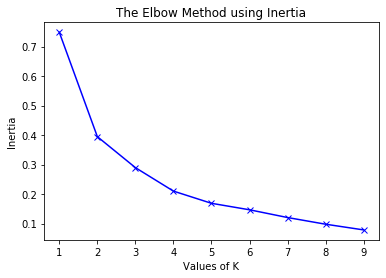

In [76]:
# plt.figure(figsize=(15,15))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

#### K Means clustering of the prepared data set 'Toronto_grouped_clustering' using the choosen k clusters value
* K=4 or 5 seem reasonable values to use, I choose k=5

In [77]:
# set the number of clusters to where the elbow on the inertia graph is appearing
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=10, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 0, 4, 0, 0, 0])

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [78]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged # check the last columns!

,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0.0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Mexican Restaurant,Cosmetics Shop,Brewery,Restaurant
1,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0.0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Bakery,Plaza,Pizza Place,Bookstore,Bubble Tea Shop
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.0,Coffee Shop,Café,Restaurant,Hotel,Diner,Cosmetics Shop,Breakfast Spot,Beer Bar,Italian Restaurant,Bakery
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0.0,Coffee Shop,Cocktail Bar,Café,Bakery,Cheese Shop,Steakhouse,Seafood Restaurant,Beer Bar,Farmers Market,Creperie
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0.0,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Bubble Tea Shop,Salad Place,Japanese Restaurant
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,4.0,Grocery Store,Café,Park,Nightclub,Diner,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Candy Store
7,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0.0,Coffee Shop,Café,Bar,Steakhouse,Asian Restaurant,Restaurant,Sushi Restaurant,Burger Joint,Thai Restaurant,Gym
8,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,0.0,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Restaurant,Scenic Lookout,Fried Chicken Joint,Brewery,History Museum
9,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,0.0,Coffee Shop,Hotel,Café,Italian Restaurant,Restaurant,Gastropub,Bar,Seafood Restaurant,Steakhouse,American Restaurant


#### Cleaning up rows with no venues data, set cluster labels as integers
* Ignore the warning "SettingWithCopy' as it does not affect the result

In [79]:
# dropping Neighbourhoods rows where no data is avaliable
toronto_merged=toronto_merged.dropna()

In [81]:
# converting Cluster_Labels to integer
toronto_merged['Cluster_Labels'] = toronto_merged.Cluster_Labels.astype(int)

C:\Users\Sorin\Anaconda3\envs\mudpie\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
# Optional: save toronto_merged df
toronto_merged.to_csv('toronto_merged.csv', index=False)

In [83]:
toronto_merged

,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Mexican Restaurant,Cosmetics Shop,Brewery,Restaurant
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Bakery,Plaza,Pizza Place,Bookstore,Bubble Tea Shop
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Hotel,Diner,Cosmetics Shop,Breakfast Spot,Beer Bar,Italian Restaurant,Bakery
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Café,Bakery,Cheese Shop,Steakhouse,Seafood Restaurant,Beer Bar,Farmers Market,Creperie
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Bubble Tea Shop,Salad Place,Japanese Restaurant
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,4,Grocery Store,Café,Park,Nightclub,Diner,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Candy Store
7,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0,Coffee Shop,Café,Bar,Steakhouse,Asian Restaurant,Restaurant,Sushi Restaurant,Burger Joint,Thai Restaurant,Gym
8,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,0,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Restaurant,Scenic Lookout,Fried Chicken Joint,Brewery,History Museum
9,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,0,Coffee Shop,Hotel,Café,Italian Restaurant,Restaurant,Gastropub,Bar,Seafood Restaurant,Steakhouse,American Restaurant
10,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,0,Coffee Shop,Café,Hotel,Restaurant,Steakhouse,American Restaurant,Seafood Restaurant,Italian Restaurant,Gym,Gastropub


### Creating map of clusters for Downtown Toronto neighbourhoods

In [84]:
# create map
map_clusters = folium.Map(location=[To_latitude, To_longitude], zoom_start=13, control_scale = True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining the Clusters 
* Examine each cluster and determine the discriminating venue categories that distinguish each cluster

#### Cluster 1 - Airpot, Harbour

In [128]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,"CN Tower, Bathurst Quay, Island airport, Harbo...",0,Airport Service,Airport Terminal,Harbor / Marina,Bar,Coffee Shop,Sculpture Garden,Boutique,Boat or Ferry,Airport Food Court,Airport Lounge


#### Cluster 2 - Park, playground, leisure area

In [129]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Rosedale,1,Park,Playground,Trail,Department Store,Empanada Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


#### Cluster 3 - Stores, Cafe, Restaurants

In [130]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Christie,2,Grocery Store,Café,Park,Athletics & Sports,Diner,Italian Restaurant,Restaurant,Baby Store,Candy Store,Nightclub


#### Cluster 4 - City Center - Coffee shops, Restaurants, Bars

In [131]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Harbourfront,3,Coffee Shop,Park,Bakery,Pub,Mexican Restaurant,Café,Restaurant,Breakfast Spot,Performing Arts Venue,Hotel
2,"Ryerson, Garden District",3,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Sporting Goods Shop,Bookstore,Ramen Restaurant,Pizza Place
3,St. James Town,3,Coffee Shop,Café,Restaurant,Hotel,Cosmetics Shop,Breakfast Spot,Bakery,Diner,Italian Restaurant,Beer Bar
4,Berczy Park,3,Coffee Shop,Cocktail Bar,Café,Bakery,Cheese Shop,Steakhouse,Beer Bar,Seafood Restaurant,Farmers Market,Sandwich Place
5,Central Bay Street,3,Coffee Shop,Café,Italian Restaurant,Ice Cream Shop,Sandwich Place,Burger Joint,Chinese Restaurant,Bakery,Juice Bar,Japanese Restaurant
7,"Adelaide, King, Richmond",3,Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Bakery,Burger Joint,Restaurant
8,"Harbourfront East, Toronto Islands, Union Station",3,Coffee Shop,Aquarium,Hotel,Café,Brewery,Fried Chicken Joint,Restaurant,Scenic Lookout,Italian Restaurant,Plaza
9,"Design Exchange, Toronto Dominion Centre",3,Coffee Shop,Hotel,Café,Italian Restaurant,Restaurant,Bakery,Bar,Steakhouse,American Restaurant,Seafood Restaurant
10,"Commerce Court, Victoria Hotel",3,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Seafood Restaurant,Steakhouse,Gastropub,Deli / Bodega,American Restaurant
11,"Harbord, University of Toronto",3,Café,Bakery,Italian Restaurant,Japanese Restaurant,Sandwich Place,Restaurant,Bookstore,Bar,Massage Studio,Dessert Shop


#### Cluster 5 -  Grocery, Cafe, Restaurants, Stores

In [54]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Christie,4,Grocery Store,Café,Park,Nightclub,Diner,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Candy Store
